# FIN41360 Assignment 1 – Data Sanity Checks

This notebook checks that the Fama–French datasets for Assignment 1 are correctly
downloaded, parsed, and aligned:

- 30 Industry Portfolios (value-weighted, monthly)
- Fama–French 3-factor model (monthly)
- Fama–French 5-factor (2x3) model (monthly)

We’ll verify shapes, sample periods, and basic summary statistics.

> EXPLAIN: This notebook is purely for validation so that we can trust the
> inputs before building mean–variance frontiers.

In [1]:
# Core imports
import pandas as pd
import numpy as np

# Local helpers for this assignment
from fin41360.process_french import (
    load_industry_30_monthly,
    load_ff3_monthly,
    load_ff5_monthly,
)

# EXPLAIN: Keeping all French-data logic in fin41360.process_french
# avoids duplicating parsing/cleaning code in notebooks.

In [2]:
# Load 30-industry value-weighted monthly gross returns
ind = load_industry_30_monthly()

# Load FF3 and FF5 factors (excess returns) + RF (gross)
ff3, rf3 = load_ff3_monthly()
ff5, rf5 = load_ff5_monthly()

print("Industries:", ind.shape, ind.index.min().date(), "→", ind.index.max().date())
print("FF3:", ff3.shape, "RF len:", len(rf3))
print("FF5:", ff5.shape, "RF len:", len(rf5))

Industries: (552, 30) 1980-01-31 → 2025-12-31
FF3: (552, 3) RF len: 552
FF5: (552, 5) RF len: 552


In [3]:
# Industry portfolios: mean and volatility
ind_stats = ind.describe().T[["mean", "std"]]
ind_stats.head()

# EXPLAIN: Values here are gross returns (R = 1 + r); for interpretation
# you may mentally subtract 1 to get net monthly returns.

,mean,std
Food,1.010910,0.041520
Beer,1.011961,0.049121
Smoke,1.014728,0.064563
Games,1.012291,0.071404
Books,1.008700,0.059752


In [4]:
ind.head()           # first rows
ind.tail()           # last rows
ind.describe().T     # summary stats
ind.sample(10)       # random sample of rows
list(ind.columns)    # column names


['Food',
 'Beer',
 'Smoke',
 'Games',
 'Books',
 'Hshld',
 'Clths',
 'Hlth',
 'Chems',
 'Txtls',
 'Cnstr',
 'Steel',
 'FabPr',
 'ElcEq',
 'Autos',
 'Carry',
 'Mines',
 'Coal',
 'Oil',
 'Util',
 'Telcm',
 'Servs',
 'BusEq',
 'Paper',
 'Trans',
 'Whlsl',
 'Rtail',
 'Meals',
 'Fin',
 'Other']

| Date                |   Food |   Beer |   Smoke |   Games |   Books |   Hshld |   Clths |   Hlth |   Chems |   Txtls |   Cnstr |   Steel |   FabPr |   ElcEq |   Autos |   Carry |   Mines |   Coal |    Oil |   Util |   Telcm |   Servs |   BusEq |   Paper |   Trans |   Whlsl |   Rtail |   Meals |    Fin |   Other |
|---------------------|--------|--------|---------|---------|---------|---------|---------|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|--------|--------|--------|---------|---------|---------|---------|---------|---------|---------|---------|--------|---------|
| 1980-01-31 00:00:00 | 1.0302 | 1.1089 |  0.9937 |  1.0653 |  1.0388 |  1.0128 |  1.0139 | 0.9871 |  1.0433 |  1.0488 |  1.0804 |  1.1758 |  1.0793 |  1.0809 |  1.0987 |  1.2427 |  1.1599 | 1.081  | 1.1413 | 1.0155 |  0.9793 |  1.0687 |  1.0727 |  1.0529 |  1.093  |  1.0546 |  0.9955 |  1.051  | 1.021  |  1.0782 |
| 1980-02-29 00:00:00 | 0.9423 | 0.9766 |  0.9514

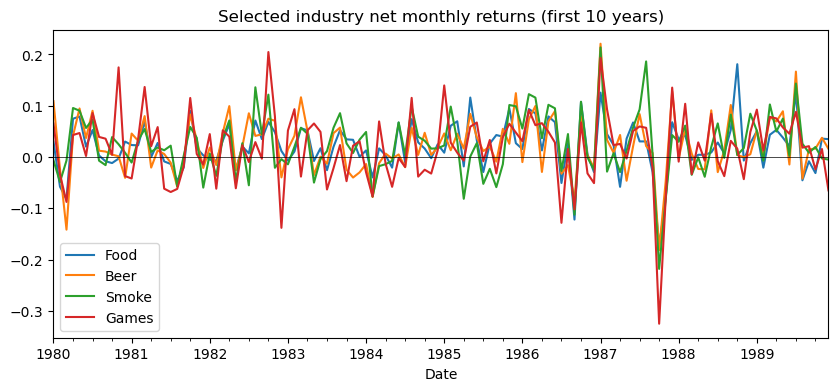

In [5]:
from tabulate import tabulate
print(tabulate(ind.head(20), headers="keys", tablefmt="github"))
import matplotlib.pyplot as plt

# Plot a few industry series to eyeball behaviour
ind[["Food", "Beer", "Smoke", "Games"]].iloc[:120].add(-1).plot(figsize=(10, 4))
plt.title("Selected industry net monthly returns (first 10 years)")
plt.axhline(0, color="black", linewidth=0.5)
plt.show()
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly
from fin41360.mv_frontier import compute_moments_from_gross, gmv_weights, tangency_weights, efficient_frontier

ind_gross = load_industry_30_monthly()
ind_net = ind_gross - 1.0

mu, Sigma = compute_moments_from_gross(ind_gross)

ff3, rf = load_ff3_monthly()
rf_mean = float((rf - 1.0).mean())  # average monthly RF (net)

w_gmv = gmv_weights(Sigma)
w_tan = tangency_weights(mu, Sigma, rf_mean)

target_means, vols, weights_grid = efficient_frontier(mu, Sigma)

## Scope 2 – 30-Industry MV Frontier (Sample Estimates)

The following cells construct the **unconstrained mean–variance frontier** for the
30 Fama–French industry portfolios using closed-form formulas, and identify the
GMV and tangency portfolios for Question 2(a)–(b).

> EXPLAIN: Scope 1 cells above focus on data sanity checks; scope 2 cells below
> perform the actual frontier and key-portfolio computations.

In [6]:
# Scope 2: Setup for MV frontier
# Chart conventions: frontier-chart-drawing skill (.cursor/skills/frontier-chart-drawing/)

import matplotlib.pyplot as plt
import seaborn as sns

from fin41360.mv_frontier import (
    compute_moments_from_gross,
    gmv_weights,
    tangency_weights,
    efficient_frontier,
    portfolio_stats,
)
from fin41360.plot_styles import (
    style,
    FRONTIER_STYLE,
    CML_STYLE,
    GMV_STYLE,
    TAN_STYLE,
    ESTIMATOR_STYLE,
    SCOPE3_PLOT_STYLE,
    scope6_legend_handles,
    scope6_panel_legend_handles,
)

# Global save format for figures (set near top of notebook per skill)
SAVE_FIG_FORMAT = "png"

sns.set_theme(style="whitegrid", context="notebook")

# Use the same industry and RF data loaded above
ind_gross = ind  # (T, 30), R = 1 + r

# Re-load RF to be explicit (keeps notebook self-contained if re-run from here)
ff3_for_frontier, rf_gross_for_frontier = load_ff3_monthly()

ind_net = ind_gross - 1.0
rf_net = rf_gross_for_frontier - 1.0

print("Scope 2 sample period:")
print("Industries:", ind_net.shape, ind_net.index.min().date(), "→", ind_net.index.max().date())
print("RF:", rf_net.shape, rf_net.index.min().date(), "→", rf_net.index.max().date())

# Compute sample mean vector and covariance matrix (net monthly returns)
mu, Sigma = compute_moments_from_gross(ind_gross)

# Average monthly risk-free rate over the same sample
rf_mean = float(rf_net.mean())
print(f"Average monthly risk-free rate (net): {rf_mean:.4%}")

Scope 2 sample period:
Industries: (552, 30) 1980-01-31 → 2025-12-31
RF: (552,) 1980-01-31 → 2025-12-31
Average monthly risk-free rate (net): 0.3297%


## Scope 2B/2C – Bayes–Stein Frontiers (Means and Means+Covariance)

In this section we:

- Apply Jorion-style Bayes–Stein shrinkage to the **mean vector** of industry returns.
- Apply a **light covariance shrinkage** towards a scaled identity matrix.
- Construct three frontiers for the 30 industries:
  - **Sample**: `(mu, Sigma)`
  - **BS-mean**: `(mu_bs, Sigma)`
  - **BS-mean+cov**: `(mu_bs, Sigma_bs)`
- Compare GMV and tangency portfolios across these frontiers, focusing on
  expected excess return, volatility, and Sharpe ratio.

> EXPLAIN: We shrink towards the cross-sectional grand mean (Jorion, 1986)
> and use a modest covariance shrinkage (λ ≈ 0.1) because T >> N in our
> sample. Alternatives (e.g., constant-correlation target, Ledoit–Wolf)
> are possible but add complexity without clear benefits in this setting.

In [7]:
# Scope 2B/2C: Bayes–Stein means and covariance

from fin41360.bayes_stein import bayes_stein_means, shrink_covariance_identity
from fin41360.analyse_frontiers import compare_frontiers, print_sharpe_comparison

# We already have ind_gross, mu, Sigma, rf_net, rf_mean from earlier cells
T = ind_gross.shape[0]
N = ind_gross.shape[1]
print(f"Sample length T={T}, number of industries N={N}")

# --- Bayes–Stein shrinkage of means (towards cross-sectional grand mean) ---
bs_result = bayes_stein_means(mu, Sigma, T=T)
mu_bs = bs_result.mu_bs
print(f"Bayes–Stein shrinkage intensity (means): {bs_result.shrinkage_intensity:.3f}")
print(f"Grand mean target (monthly net): {bs_result.target_mean:.4%}")

# --- Light covariance shrinkage towards scaled identity ---
Sigma_bs = shrink_covariance_identity(Sigma, shrinkage=0.1)

# Sanity check: all covariance matrices should be symmetric and positive semi-definite
for name, S in [("sample", Sigma), ("BS-cov", Sigma_bs)]:
    eigvals = np.linalg.eigvalsh(S)
    print(f"{name} Sigma: min eigenvalue = {eigvals.min():.4e}, max = {eigvals.max():.4e}")

Sample length T=552, number of industries N=30
Bayes–Stein shrinkage intensity (means): 0.005
Grand mean target (monthly net): 1.0853%
sample Sigma: min eigenvalue = 2.9721e-04, max = 7.0464e-02
BS-cov Sigma: min eigenvalue = 6.7893e-04, max = 6.3829e-02


In [8]:
# Scope 2B/2C: Compare GMV and tangency across sample and Bayes–Stein frontiers

# Package frontier definitions in terms of (mu, Sigma)
frontiers = {
    "sample": (mu, Sigma),
    "bs_mean": (mu_bs, Sigma),
    "bs_mean_cov": (mu_bs, Sigma_bs),
}

summary = compare_frontiers(frontiers, rf_mean)
summary


,portfolio,label,mean,vol,excess_mean,sharpe
0,GMV,sample,0.009733,0.031396,0.006435,0.204973
1,TAN,sample,0.017633,0.046860,0.014336,0.305928
2,GMV,bs_mean,0.009738,0.031396,0.006441,0.205144
3,TAN,bs_mean,0.017556,0.046715,0.014259,0.305236
4,GMV,bs_mean_cov,0.010071,0.032117,0.006773,0.210897
5,TAN,bs_mean_cov,0.015950,0.043897,0.012653,0.288244


In [9]:
# Scope 2C: Rule-based commentary on Sharpe ratio changes (Question 2c)

print_sharpe_comparison(summary, base_label="sample")

[bs_mean] Tangency Sharpe change vs sample: -0.001 → Sharpe ratio is very similar to the sample-based frontier.
[bs_mean_cov] Tangency Sharpe change vs sample: -0.018 → Sharpe ratio is very similar to the sample-based frontier.


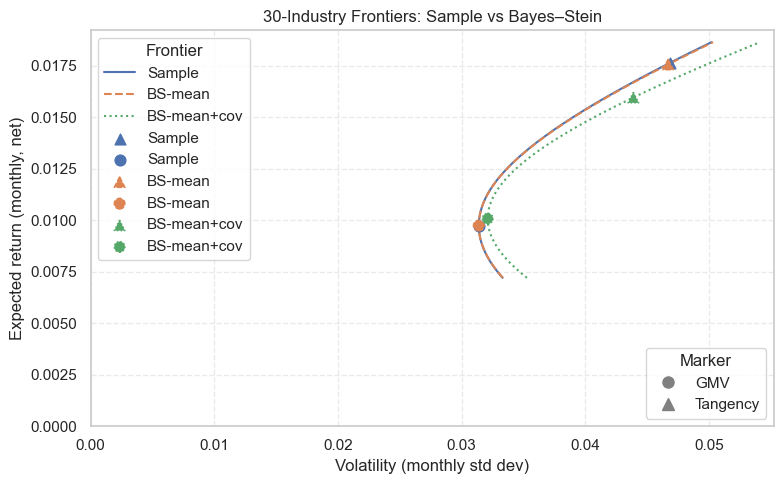

In [10]:
# Scope 2B/2C: Overlay plot of sample vs Bayes–Stein frontiers (skill: frontier-chart-drawing)

import matplotlib.lines as mlines

tan = summary[summary["portfolio"] == "TAN"].set_index("label")
gmv = summary[summary["portfolio"] == "GMV"].set_index("label")

mu_targets = np.concatenate([
    tan["mean"].values,
    gmv["mean"].values,
    mu,  # individual industry means
])
mu_min = float(mu_targets.min()) - 0.001
mu_max = float(mu_targets.max()) + 0.001

# Generate frontiers for all three (using the same mu/Sigma variants)
front_sample_means, front_sample_vols, _ = efficient_frontier(mu, Sigma, n_points=200, mu_min=mu_min, mu_max=mu_max)
front_bsmean_means, front_bsmean_vols, _ = efficient_frontier(mu_bs, Sigma, n_points=200, mu_min=mu_min, mu_max=mu_max)
front_bscov_means, front_bscov_vols, _ = efficient_frontier(mu_bs, Sigma_bs, n_points=200, mu_min=mu_min, mu_max=mu_max)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(front_sample_vols, front_sample_means, **style("frontier", "sample"))
ax.plot(front_bsmean_vols, front_bsmean_means, **style("frontier", "bs_mean"))
ax.plot(front_bscov_vols, front_bscov_means, **style("frontier", "bs_mean_cov"))

# Highlight GMV and tangency portfolios for each frontier
for label in ["sample", "bs_mean", "bs_mean_cov"]:
    mu_tan_f = float(tan.loc[label, "mean"])
    vol_tan_f = float(tan.loc[label, "vol"])
    ax.scatter(vol_tan_f, mu_tan_f, **style("tan", label))
    mu_gmv_f = float(gmv.loc[label, "mean"])
    vol_gmv_f = float(gmv.loc[label, "vol"])
    ax.scatter(vol_gmv_f, mu_gmv_f, **style("gmv", label))

ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel("Volatility (monthly std dev)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title("30-Industry Frontiers: Sample vs Bayes–Stein")
leg1 = ax.legend(loc="upper left", title="Frontier")
ax.add_artist(leg1)
marker_handles = [
    mlines.Line2D([], [], color="gray", marker="o", linestyle="None", markersize=8, label="GMV"),
    mlines.Line2D([], [], color="gray", marker="^", linestyle="None", markersize=8, label="Tangency"),
]
ax.legend(handles=marker_handles, loc="lower right", title="Marker")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# EXPLAIN: By expanding the target-mean range using both GMV and tangency
# means, we ensure that all key portfolios lie on the plotted frontiers.
# This plot directly supports Question 2(c) by showing how shrinkage of
# means and covariance changes the location and shape of the efficient
# frontier and both GMV and tangency portfolios.

In [11]:
# Scope 2: GMV and tangency portfolios

# Global minimum-variance portfolio
w_gmv = gmv_weights(Sigma)
mu_gmv, vol_gmv = portfolio_stats(w_gmv, mu, Sigma)

# Tangency portfolio (unconstrained, using average RF)
w_tan = tangency_weights(mu, Sigma, rf_mean)
mu_tan, vol_tan = portfolio_stats(w_tan, mu, Sigma)

print(f"GMV:  mean={mu_gmv:.4%}, vol={vol_gmv:.4%}")
print(f"TAN:  mean={mu_tan:.4%}, vol={vol_tan:.4%}")

GMV:  mean=0.9733%, vol=3.1396%
TAN:  mean=1.7633%, vol=4.6860%


## Scope 3 – 30 Stocks (One per Industry) and Comparison to Industries

We load monthly returns for 30 individual stocks (one per Fama–French industry),
align the sample period with the industry data so that both datasets share the same
months with no missing values, then repeat the sample and Bayes–Stein frontier
analysis on stocks and compare to the 30-industry frontiers.

In [12]:
# Scope 3: Load 30-stock monthly returns and align sample period with industries

from fin41360.stock_data import load_stock_returns_monthly, get_common_sample_period

# Load stocks over the same range we use for industries (some tickers may have shorter history)
stocks_gross = load_stock_returns_monthly(start="1980-01", end="2025-12", use_cache=True)
print("Stocks (raw):", stocks_gross.shape, stocks_gross.index.min().date(), "→", stocks_gross.index.max().date())

# Restrict to common period with no missing values in either dataset
common_start, common_end = get_common_sample_period(ind, stocks_gross)
print(f"Common sample period (no NaNs): {common_start} to {common_end}")

# TODO: find tickers which provide a longer history (see fin41360/stock_data.py).
# If the common period is short (e.g. only 2019–2025), frontier/Sharpe estimates
# will be noisier; the comparison with industries remains valid but could be
# strengthened with a longer overlap.

# Align industry and stock data to the common period
ind_common = ind.loc[common_start:common_end].dropna(how="any")
stocks_common = stocks_gross.loc[common_start:common_end].dropna(how="any")
# Sanity: same index
assert ind_common.index.equals(stocks_common.index), "Industry and stock date indices should match"
print("Aligned shapes:", ind_common.shape, stocks_common.shape)

Stocks (raw): (551, 30) 1980-01-31 → 2025-11-30
Common sample period (no NaNs): 2019-04 to 2025-11
Aligned shapes: (80, 30) (80, 30)


In [ ]:
# Scope 3: Moments and Bayes–Stein for industries and stocks (common period only)

# Use the same T for both so the comparison is like-for-like
T_common = len(ind_common)
rf_common = float(rf_net.loc[ind_common.index].mean())

# Industry moments on common period
mu_ind, Sigma_ind = compute_moments_from_gross(ind_common)
bs_ind = bayes_stein_means(mu_ind, Sigma_ind, T=T_common)
Sigma_ind_bs = shrink_covariance_identity(Sigma_ind, shrinkage=0.1)

# Stock moments on common period
mu_stk, Sigma_stk = compute_moments_from_gross(stocks_common)
bs_stk = bayes_stein_means(mu_stk, Sigma_stk, T=T_common)
Sigma_stk_bs = shrink_covariance_identity(Sigma_stk, shrinkage=0.1)

print(f"Common period: {common_start} to {common_end}, T = {T_common}, rf (monthly net) = {rf_common:.4%}")
print("Industry BS shrinkage (means):", bs_ind.shrinkage_intensity)
print("Stock BS shrinkage (means):", bs_stk.shrinkage_intensity)

Common period: 2019-04 to 2025-11, T = 80, rf (monthly net) = 0.2149%
Industry BS shrinkage (means): 0.003902500292214437
Stock BS shrinkage (means): 0.007891184549728498


In [ ]:
# Scope 3: Compare GMV and tangency across industries vs stocks (common period)

frontiers_ind = {
    "ind_sample": (mu_ind, Sigma_ind),
    "ind_bs_mean": (bs_ind.mu_bs, Sigma_ind),
    "ind_bs_mean_cov": (bs_ind.mu_bs, Sigma_ind_bs),
}
frontiers_stk = {
    "stk_sample": (mu_stk, Sigma_stk),
    "stk_bs_mean": (bs_stk.mu_bs, Sigma_stk),
    "stk_bs_mean_cov": (bs_stk.mu_bs, Sigma_stk_bs),
}

summary_ind = compare_frontiers(frontiers_ind, rf_common)
summary_stk = compare_frontiers(frontiers_stk, rf_common)

print("--- Industries (common period) ---")
print(summary_ind.to_string())
print("\n--- Stocks (common period) ---")
print(summary_stk.to_string())

--- Industries (common period) ---
  portfolio            label      mean       vol  excess_mean    sharpe
0       GMV       ind_sample  0.004098  0.026489     0.001949  0.073578
1       TAN       ind_sample  0.327230  0.342104     0.325081  0.950240
2       GMV      ind_bs_mean  0.004129  0.026489     0.001980  0.074748
3       TAN      ind_bs_mean  0.319723  0.335474     0.317575  0.946646
4       GMV  ind_bs_mean_cov  0.006183  0.030686     0.004034  0.131477
5       TAN  ind_bs_mean_cov  0.114173  0.161696     0.112024  0.692808

--- Stocks (common period) ---
  portfolio            label      mean       vol  excess_mean    sharpe
0       GMV       stk_sample  0.003460  0.030070     0.001311  0.043610
1       TAN       stk_sample  0.470308  0.568159     0.468159  0.823994
2       GMV      stk_bs_mean  0.003522  0.030070     0.001373  0.045674
3       TAN      stk_bs_mean  0.442262  0.538284     0.440114  0.817623
4       GMV  stk_bs_mean_cov  0.006847  0.031963     0.004698  0.1469

In [ ]:
# Scope 3: Industry vs stock comparison table (for report)

# Build a compact side-by-side comparison: industries vs stocks for each estimator
comparison_rows = []
for est in ["sample", "bs_mean", "bs_mean_cov"]:
    lab_ind = f"ind_{est}"
    lab_stk = f"stk_{est}"
    for port in ["GMV", "TAN"]:
        r_ind = summary_ind[(summary_ind["label"] == lab_ind) & (summary_ind["portfolio"] == port)].iloc[0]
        r_stk = summary_stk[(summary_stk["label"] == lab_stk) & (summary_stk["portfolio"] == port)].iloc[0]
        comparison_rows.append({
            "estimator": est,
            "portfolio": port,
            "ind_mean": r_ind["mean"],
            "stk_mean": r_stk["mean"],
            "ind_vol": r_ind["vol"],
            "stk_vol": r_stk["vol"],
            "ind_sharpe": r_ind["sharpe"],
            "stk_sharpe": r_stk["sharpe"],
        })

scope3_comparison = pd.DataFrame(comparison_rows)
scope3_comparison

,estimator,portfolio,ind_mean,stk_mean,ind_vol,stk_vol,ind_sharpe,stk_sharpe
0,sample,GMV,0.004098,0.003460,0.026489,0.030070,0.073578,0.043610
1,sample,TAN,0.327230,0.470308,0.342104,0.568159,0.950240,0.823994
2,bs_mean,GMV,0.004129,0.003522,0.026489,0.030070,0.074748,0.045674
3,bs_mean,TAN,0.319723,0.442262,0.335474,0.538284,0.946646,0.817623
4,bs_mean_cov,GMV,0.006183,0.006847,0.030686,0.031963,0.131477,0.146988
5,bs_mean_cov,TAN,0.114173,0.105961,0.161696,0.150248,0.692808,0.690936


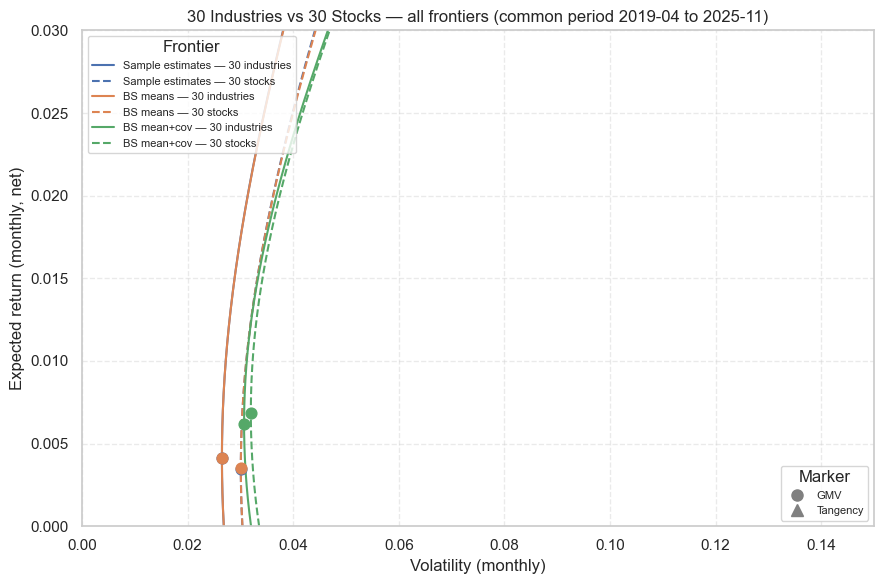

In [16]:
# Scope 3: Single-plot overlay — all three frontiers (industry & stock) with shared styling
# SCOPE3_PLOT_STYLE is imported from fin41360.plot_styles

# Build frontier (vol, mean) curves for each estimator × universe (axes are clipped to 0–0.15 vol, 0–0.03 mean)
mu_min_s3 = 0.0
mu_max_s3 = 0.04
n_pts = 200
m_ind_s, v_ind_s, _ = efficient_frontier(mu_ind, Sigma_ind, n_points=n_pts, mu_min=mu_min_s3, mu_max=mu_max_s3)
m_stk_s, v_stk_s, _ = efficient_frontier(mu_stk, Sigma_stk, n_points=n_pts, mu_min=mu_min_s3, mu_max=mu_max_s3)
m_ind_b, v_ind_b, _ = efficient_frontier(bs_ind.mu_bs, Sigma_ind, n_points=n_pts, mu_min=mu_min_s3, mu_max=mu_max_s3)
m_stk_b, v_stk_b, _ = efficient_frontier(bs_stk.mu_bs, Sigma_stk, n_points=n_pts, mu_min=mu_min_s3, mu_max=mu_max_s3)
m_ind_c, v_ind_c, _ = efficient_frontier(bs_ind.mu_bs, Sigma_ind_bs, n_points=n_pts, mu_min=mu_min_s3, mu_max=mu_max_s3)
m_stk_c, v_stk_c, _ = efficient_frontier(bs_stk.mu_bs, Sigma_stk_bs, n_points=n_pts, mu_min=mu_min_s3, mu_max=mu_max_s3)

est_curves = [
    ("sample", "industry", v_ind_s, m_ind_s), ("sample", "stock", v_stk_s, m_stk_s),
    ("bs_mean", "industry", v_ind_b, m_ind_b), ("bs_mean", "stock", v_stk_b, m_stk_b),
    ("bs_mean_cov", "industry", v_ind_c, m_ind_c), ("bs_mean_cov", "stock", v_stk_c, m_stk_c),
]

fig, ax = plt.subplots(figsize=(9, 6))
for est, univ, v, m in est_curves:
    sty_est = SCOPE3_PLOT_STYLE["estimator"][est]
    sty_univ = SCOPE3_PLOT_STYLE["universe"][univ]
    ax.plot(v, m, color=sty_est["color"], linestyle=sty_univ["linestyle"],
            label=f"{sty_est['label']} — {sty_univ['label']}")

# (mu, Sigma) per estimator × universe for GMV/TAN points
point_specs = [
    ("sample", "industry", mu_ind, Sigma_ind), ("sample", "stock", mu_stk, Sigma_stk),
    ("bs_mean", "industry", bs_ind.mu_bs, Sigma_ind), ("bs_mean", "stock", bs_stk.mu_bs, Sigma_stk),
    ("bs_mean_cov", "industry", bs_ind.mu_bs, Sigma_ind_bs), ("bs_mean_cov", "stock", bs_stk.mu_bs, Sigma_stk_bs),
]
for est, univ, mu_f, Sigma_f in point_specs:
    wg = gmv_weights(Sigma_f)
    wt = tangency_weights(mu_f, Sigma_f, rf_common)
    mg, vg = portfolio_stats(wg, mu_f, Sigma_f)
    mt, vt = portfolio_stats(wt, mu_f, Sigma_f)
    c = SCOPE3_PLOT_STYLE["estimator"][est]["color"]
    ax.scatter([vg], [mg], color=c, marker=SCOPE3_PLOT_STYLE["portfolio_marker"]["GMV"], s=60, zorder=5)
    ax.scatter([vt], [mt], color=c, marker=SCOPE3_PLOT_STYLE["portfolio_marker"]["TAN"], s=60, zorder=5)

ax.set_xlim(0, 0.15)
ax.set_ylim(0, 0.03)  # anchor at (0,0) per skill
ax.set_xlabel("Volatility (monthly)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title(f"30 Industries vs 30 Stocks — all frontiers (common period {common_start} to {common_end})")
leg1 = ax.legend(loc="upper left", fontsize=8, title="Frontier")
ax.add_artist(leg1)
import matplotlib.lines as mlines
marker_handles = [
    mlines.Line2D([], [], color="gray", marker="o", linestyle="None", markersize=8, label="GMV"),
    mlines.Line2D([], [], color="gray", marker="^", linestyle="None", markersize=8, label="Tangency"),
]
ax.legend(handles=marker_handles, loc="lower right", fontsize=8, title="Marker")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Reminds me of ESG vs full universe. The frontier of a portfolio from individual stocks is going to be less diversified than the portfolio of portfolios. NOTE.

#TODO: Is there a better way to display this legend. dashed meaning stocks, full meaning industry.

**Scope 3 interpretation (Q3):**

**Why the frontiers differ:** Industry portfolios are diversified baskets of many firms, so they tend to show a better risk–return trade-off (frontier shifted left/up) than 30 individual stocks. Single-name stocks carry more **idiosyncratic risk** that is not rewarded in a mean–variance sense, so the stock frontier typically sits to the right and/or below the industry frontier. **Estimation error** is large when the number of assets is not small relative to the sample length: with a short common period (e.g. 2019–2025), sample and BS-mean tangency portfolios often have extreme weights and unrealistically high mean/vol, which is why we clip axes and note "off chart." **Bayes–Stein mean + covariance** shrinkage (BS-mean_cov) produces a more stable tangency portfolio and a plausible frontier; the third panel shows that industry vs stock comparison on this estimator. In the report, use the comparison table above and these three panels to discuss diversification, idiosyncratic risk, estimation error, and the role of BS-mean_cov.

## Scope 4 (Question 4): 30 Industries + Risk-Free Asset

We sketch the **monthly MV efficient frontier for the 30 industry portfolios and the risk-free asset** using **sample** estimates of expected returns and variance–covariance matrix. The risk-free rate is from the Fama–French factors (same data library); we use its average over the same sample period as the industry returns. The efficient set with a risk-free asset is the **capital market line (CML)** from the risk-free rate through the tangency portfolio on the risky frontier, then the upper limb of the risky frontier beyond tangency. We compare this to the **industries-only** frontier from Question 2.

Scope 4 sample period (industries and risk-free aligned):
  1980-01-31 to 2025-12-31, T = 552
  Average monthly risk-free rate (net): 0.3297%


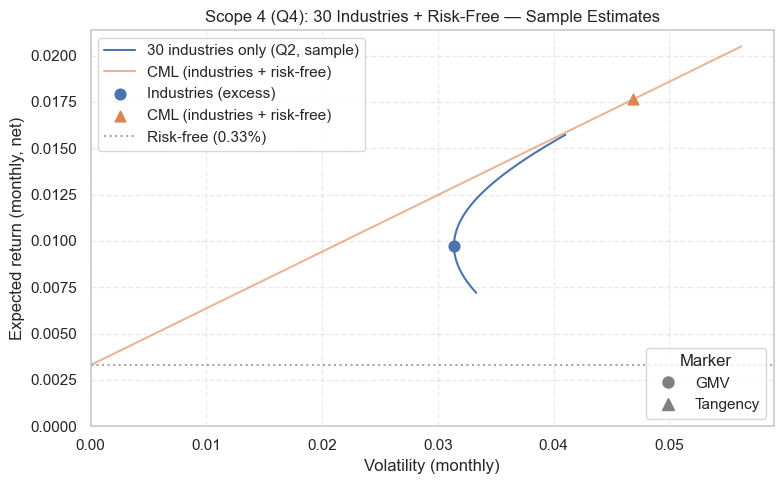


Tangency (sample): μ = 1.7633%, σ = 4.6860%, Sharpe = 0.3059
With the risk-free asset, the efficient set is the CML up to tangency, then the risky frontier above.


In [17]:
# Scope 4 (Q4): Efficient frontier for 30 industries + risk-free asset (sample estimates only)

import numpy as np
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly
from fin41360.mv_frontier import (
    compute_moments_from_gross,
    gmv_weights,
    tangency_weights,
    efficient_frontier,
    portfolio_stats,
)

# Align industry and RF to the same sample period (RF from Fama–French factors)
ind_s4 = load_industry_30_monthly()
ff3_s4, rf_gross_s4 = load_ff3_monthly()
common_idx = ind_s4.index.intersection(rf_gross_s4.index)
ind_s4 = ind_s4.loc[common_idx]
rf_net_s4 = (rf_gross_s4 - 1.0).loc[common_idx]
rf_mean_s4 = float(rf_net_s4.mean())

mu_s4, Sigma_s4 = compute_moments_from_gross(ind_s4)
T_s4 = len(ind_s4)

print("Scope 4 sample period (industries and risk-free aligned):")
print(f"  {common_idx.min().date()} to {common_idx.max().date()}, T = {T_s4}")
print(f"  Average monthly risk-free rate (net): {rf_mean_s4:.4%}")

# Risky-only frontier (30 industries, sample) — same as Q2 for comparison
mu_min_s4 = float(mu_s4.min()) - 0.001
mu_max_s4 = float(mu_s4.max()) + 0.001
front_means, front_vols, _ = efficient_frontier(mu_s4, Sigma_s4, n_points=200, mu_min=mu_min_s4, mu_max=mu_max_s4)

# Tangency portfolio (sample) and CML
w_tan_s4 = tangency_weights(mu_s4, Sigma_s4, rf_mean_s4)
mu_tan_s4, vol_tan_s4 = portfolio_stats(w_tan_s4, mu_s4, Sigma_s4)
sharpe_tan_s4 = (mu_tan_s4 - rf_mean_s4) / vol_tan_s4 if vol_tan_s4 > 0 else np.nan

# CML: mu = rf + Sharpe * vol from (0, rf) through tangency
vol_cml = np.linspace(0, float(vol_tan_s4) * 1.2, 150)
mu_cml = rf_mean_s4 + sharpe_tan_s4 * vol_cml

# GMV for reference
w_gmv_s4 = gmv_weights(Sigma_s4)
mu_gmv_s4, vol_gmv_s4 = portfolio_stats(w_gmv_s4, mu_s4, Sigma_s4)

# Plot: industries-only frontier (Q2) vs CML (industries + RF)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(front_vols, front_means, **style("frontier", "industries", label="30 industries only (Q2, sample)"))
ax.plot(vol_cml, mu_cml, **style("cml", "cml"))
ax.scatter([vol_gmv_s4], [mu_gmv_s4], **style("gmv", "industries"))
ax.scatter([vol_tan_s4], [mu_tan_s4], **style("tan", "cml"))
ax.axhline(rf_mean_s4, color="gray", linestyle=":", alpha=0.7, label=f"Risk-free ({rf_mean_s4:.2%})")
ax.set_xlim(0, None)
ax.set_ylim(0, None)  # anchor at (0,0) per skill
ax.set_xlabel("Volatility (monthly)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title("Scope 4 (Q4): 30 Industries + Risk-Free — Sample Estimates")
leg1 = ax.legend(loc="upper left")
ax.add_artist(leg1)
import matplotlib.lines as mlines
marker_handles = [
    mlines.Line2D([], [], color="gray", marker="o", linestyle="None", markersize=8, label="GMV"),
    mlines.Line2D([], [], color="gray", marker="^", linestyle="None", markersize=8, label="Tangency"),
]
ax.legend(handles=marker_handles, loc="lower right", title="Marker")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Compare: CML dominates the risky-only frontier below tangency; they meet at tangency.
print(f"\nTangency (sample): μ = {mu_tan_s4:.4%}, σ = {vol_tan_s4:.4%}, Sharpe = {sharpe_tan_s4:.4f}")
print("With the risk-free asset, the efficient set is the CML up to tangency, then the risky frontier above.")

**Scope 4 comparison (Q4):** The **industries-only** frontier (Q2, dashed) is the parabola of risky portfolios. Adding the **risk-free asset** gives the **CML**: the efficient set is the line from the risk-free rate through the tangency portfolio. Below tangency, the CML dominates the risky-only frontier (higher return for the same volatility). At tangency they coincide; above tangency the efficient set follows the upper limb of the risky frontier. **Sample period for the risk-free rate:** we use the same dates as the 30 industry returns (aligned intersection), so the RF sample period matches the industry sample period printed above; the average monthly risk-free rate over that period is used for the tangency portfolio and CML.

## Scope 5 (Question 5): Fama–French Factor Frontiers (FF3 and FF5)

In this section we **repeat the risk-free analysis of Question 4 using Fama–French factor-mimicking portfolios** in place of the 30 industries:

- First using the **Fama/French 3 Factors** (`Mkt-RF`, `SMB`, `HML`).
- Then using the **Fama/French 5 Factors (2x3)** (`Mkt-RF`, `SMB`, `HML`, `RMW`, `CMA`).

The factor returns are already in **excess-return format** (each column is a factor return minus the risk-free rate). To make meaningful comparisons, we also express the 30-industry portfolios in **excess-return form** (industry net return minus the risk-free rate), and we work in this excess-return space with a risk-free rate of **0**. This keeps the shapes and Sharpe ratios comparable across:

- 30 industries (excess returns)
- FF3 factor portfolios (excess returns)
- FF5 factor portfolios (excess returns)

Within each universe we:

- Compute the **sample MV frontier** (no Bayes–Stein here).
- Compute **GMV** and **tangency** portfolios and their Sharpe ratios (relative to 0 RF in excess space).
- Plot frontiers and CML-style lines (from the origin through each tangency) and **compare shapes** to the industry frontier.

In [18]:
# Scope 5 (Q5): FF3 and FF5 factor frontiers in excess-return space

import numpy as np
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly, load_ff5_monthly
from fin41360.mv_frontier import (
    compute_moments_from_net,
    efficient_frontier,
    gmv_weights,
    tangency_weights,
    portfolio_stats,
)
from fin41360.analyse_frontiers import compare_frontiers

# Load industries and FF3/FF5 factors and align to common sample
ind_5 = load_industry_30_monthly()
ff3_5, rf_gross_5 = load_ff3_monthly()
ff5_5, rf_gross_5b = load_ff5_monthly()

# Use intersection of all three indices to have a common period
common_idx_5 = ind_5.index.intersection(ff3_5.index).intersection(ff5_5.index).intersection(rf_gross_5.index)
ind_5 = ind_5.loc[common_idx_5]
ff3_5 = ff3_5.loc[common_idx_5]
ff5_5 = ff5_5.loc[common_idx_5]
rf_net_5 = (rf_gross_5.loc[common_idx_5] - 1.0)

print("Scope 5 common sample period (industries, FF3, FF5, RF aligned):")
print(f"  {common_idx_5.min().date()} to {common_idx_5.max().date()}, T = {len(common_idx_5)}")

# Express everything in excess-return form (relative to RF), and work with rf = 0 in this space.
ind_net_5 = ind_5 - 1.0
ind_excess_5 = ind_net_5.sub(rf_net_5, axis=0)

mu_ind_ex, Sigma_ind_ex = compute_moments_from_net(ind_excess_5.values)
mu_ff3_ex, Sigma_ff3_ex = compute_moments_from_net(ff3_5.values)
mu_ff5_ex, Sigma_ff5_ex = compute_moments_from_net(ff5_5.values)

# Summaries for industries vs FF3 vs FF5 (all in excess-return space, rf = 0)
frontiers_ex = {
    "industries_ex": (mu_ind_ex, Sigma_ind_ex),
    "ff3_ex": (mu_ff3_ex, Sigma_ff3_ex),
    "ff5_ex": (mu_ff5_ex, Sigma_ff5_ex),
}
summary_ex = compare_frontiers(frontiers_ex, rf=0.0)
summary_ex

Scope 5 common sample period (industries, FF3, FF5, RF aligned):
  1980-01-31 to 2025-12-31, T = 552


,portfolio,label,mean,vol,excess_mean,sharpe
0,GMV,industries_ex,0.006419,0.031293,0.006419,0.205124
1,TAN,industries_ex,0.014287,0.046686,0.014287,0.306029
2,GMV,ff3_ex,0.002523,0.019144,0.002523,0.131815
3,TAN,ff3_ex,0.005593,0.028500,0.005593,0.196232
4,GMV,ff5_ex,0.002926,0.010810,0.002926,0.270663
5,TAN,ff5_ex,0.003796,0.012313,0.003796,0.308290


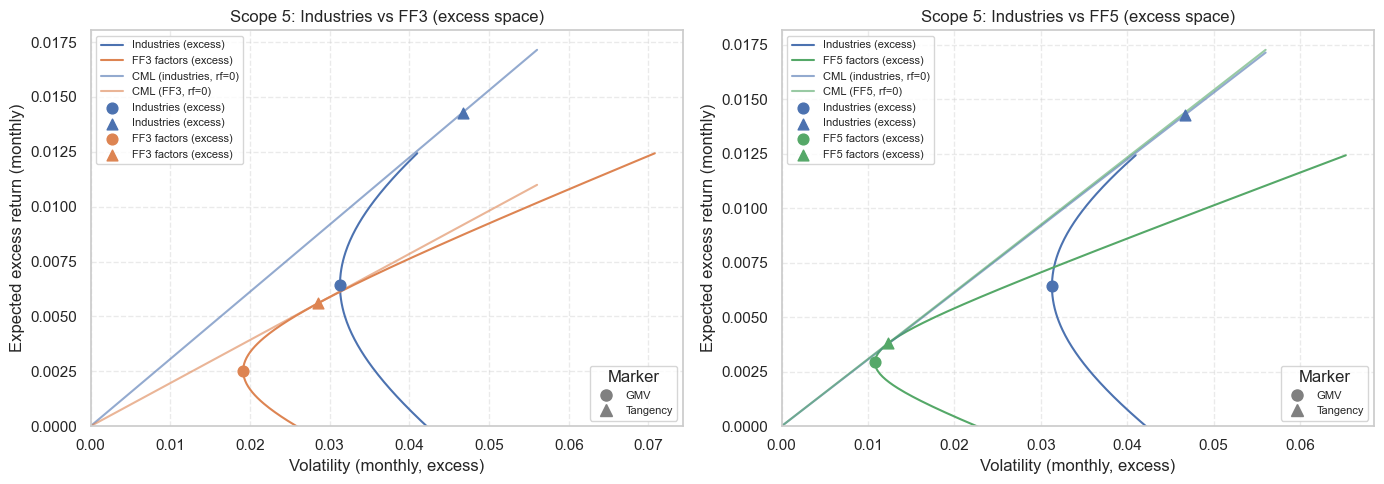

Sharpe ratios (excess space, rf=0):
  Industries: SR = 0.3060
  FF3 factors: SR = 0.1962
  FF5 factors: SR = 0.3083


In [19]:
# Scope 5: Plot frontiers and CML-style lines for industries vs FF3 vs FF5 (excess space)

# Build risky frontiers
mu_min_ex = float(min(mu_ind_ex.min(), mu_ff3_ex.min(), mu_ff5_ex.min())) - 0.001
mu_max_ex = float(max(mu_ind_ex.max(), mu_ff3_ex.max(), mu_ff5_ex.max())) + 0.001

front_ind_ex_means, front_ind_ex_vols, _ = efficient_frontier(mu_ind_ex, Sigma_ind_ex, n_points=200, mu_min=mu_min_ex, mu_max=mu_max_ex)
front_ff3_ex_means, front_ff3_ex_vols, _ = efficient_frontier(mu_ff3_ex, Sigma_ff3_ex, n_points=200, mu_min=mu_min_ex, mu_max=mu_max_ex)
front_ff5_ex_means, front_ff5_ex_vols, _ = efficient_frontier(mu_ff5_ex, Sigma_ff5_ex, n_points=200, mu_min=mu_min_ex, mu_max=mu_max_ex)

# GMV and tangency for each (rf = 0 in excess space)
def gmv_tan(mu, Sigma):
    w_g = gmv_weights(Sigma)
    mu_g, vol_g = portfolio_stats(w_g, mu, Sigma)
    w_t = tangency_weights(mu, Sigma, rf=0.0)
    mu_t, vol_t = portfolio_stats(w_t, mu, Sigma)
    sharpe_t = mu_t / vol_t if vol_t > 0 else np.nan
    return (mu_g, vol_g), (mu_t, vol_t, sharpe_t)

(gmv_ind, tan_ind) = gmv_tan(mu_ind_ex, Sigma_ind_ex)
(gmv_ff3, tan_ff3) = gmv_tan(mu_ff3_ex, Sigma_ff3_ex)
(gmv_ff5, tan_ff5) = gmv_tan(mu_ff5_ex, Sigma_ff5_ex)

(mu_g_ind, vol_g_ind), (mu_t_ind, vol_t_ind, sr_ind) = gmv_ind, tan_ind
(mu_g_ff3, vol_g_ff3), (mu_t_ff3, vol_t_ff3, sr_ff3) = gmv_ff3, tan_ff3
(mu_g_ff5, vol_g_ff5), (mu_t_ff5, vol_t_ff5, sr_ff5) = gmv_ff5, tan_ff5

# CML-style rays from origin in excess-return space
vol_grid = np.linspace(0, max(vol_t_ind, vol_t_ff3, vol_t_ff5) * 1.2, 150)
mu_cml_ind = sr_ind * vol_grid
mu_cml_ff3 = sr_ff3 * vol_grid
mu_cml_ff5 = sr_ff5 * vol_grid

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

import matplotlib.lines as mlines
marker_handles = [
    mlines.Line2D([], [], color="gray", marker="o", linestyle="None", markersize=8, label="GMV"),
    mlines.Line2D([], [], color="gray", marker="^", linestyle="None", markersize=8, label="Tangency"),
]

# Left: industries vs FF3
ax = axes[0]
ax.plot(front_ind_ex_vols, front_ind_ex_means, **style("frontier", "industries"))
ax.plot(front_ff3_ex_vols, front_ff3_ex_means, **style("frontier", "ff3"))
ax.plot(vol_grid, mu_cml_ind, **style("cml", "industries", label="CML (industries, rf=0)"))
ax.plot(vol_grid, mu_cml_ff3, **style("cml", "ff3", label="CML (FF3, rf=0)"))
ax.scatter([vol_g_ind], [mu_g_ind], **style("gmv", "industries"))
ax.scatter([vol_t_ind], [mu_t_ind], **style("tan", "industries"))
ax.scatter([vol_g_ff3], [mu_g_ff3], **style("gmv", "ff3"))
ax.scatter([vol_t_ff3], [mu_t_ff3], **style("tan", "ff3"))
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 5: Industries vs FF3 (excess space)")
ax.grid(True, linestyle="--", alpha=0.4)
leg1 = ax.legend(fontsize=8)
ax.add_artist(leg1)
ax.legend(handles=marker_handles, loc="lower right", fontsize=8, title="Marker")

# Right: industries vs FF5
ax = axes[1]
ax.plot(front_ind_ex_vols, front_ind_ex_means, **style("frontier", "industries"))
ax.plot(front_ff5_ex_vols, front_ff5_ex_means, **style("frontier", "ff5"))
ax.plot(vol_grid, mu_cml_ind, **style("cml", "industries", label="CML (industries, rf=0)"))
ax.plot(vol_grid, mu_cml_ff5, **style("cml", "ff5", label="CML (FF5, rf=0)"))
ax.scatter([vol_g_ind], [mu_g_ind], **style("gmv", "industries"))
ax.scatter([vol_t_ind], [mu_t_ind], **style("tan", "industries"))
ax.scatter([vol_g_ff5], [mu_g_ff5], **style("gmv", "ff5"))
ax.scatter([vol_t_ff5], [mu_t_ff5], **style("tan", "ff5"))
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 5: Industries vs FF5 (excess space)")
ax.grid(True, linestyle="--", alpha=0.4)
leg1 = ax.legend(fontsize=8)
ax.add_artist(leg1)
ax.legend(handles=marker_handles, loc="lower right", fontsize=8, title="Marker")

plt.tight_layout()
plt.show()

print("Sharpe ratios (excess space, rf=0):")
print(f"  Industries: SR = {sr_ind:.4f}")
print(f"  FF3 factors: SR = {sr_ff3:.4f}")
print(f"  FF5 factors: SR = {sr_ff5:.4f}")

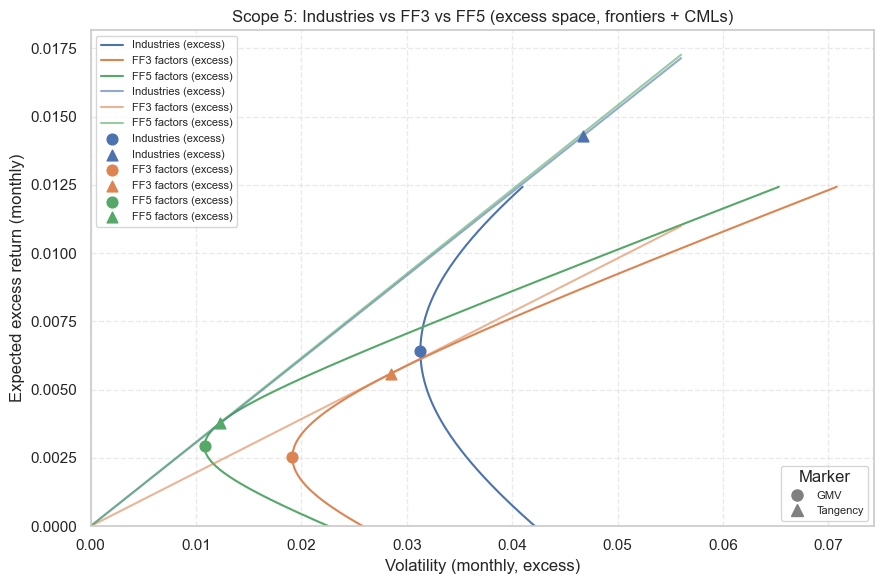

Observation: In this common panel the CML for FF5 lies very close to the industries CML,
indicating similar tangency Sharpe ratios, whereas the FF3 CML deviates more, reflecting
a different risk–return trade-off for the 3-factor span.


In [ ]:
# Scope 5: Single-panel overlay of industries, FF3, FF5 frontiers and CMLs (excess space)

fig, ax = plt.subplots(figsize=(9, 6))

# Risky frontiers (all solid per plot_styles)
ax.plot(front_ind_ex_vols, front_ind_ex_means, **style("frontier", "industries"))
ax.plot(front_ff3_ex_vols, front_ff3_ex_means, **style("frontier", "ff3"))
ax.plot(front_ff5_ex_vols, front_ff5_ex_means, **style("frontier", "ff5"))

# CML-style rays from origin (rf=0 in excess space)
ax.plot(vol_grid, mu_cml_ind, **style("cml", "industries"))
ax.plot(vol_grid, mu_cml_ff3, **style("cml", "ff3"))
ax.plot(vol_grid, mu_cml_ff5, **style("cml", "ff5"))

# GMV (o) and Tangency (^) per series (skill: frontier-chart-drawing)
ax.scatter([vol_g_ind], [mu_g_ind], **style("gmv", "industries"))
ax.scatter([vol_t_ind], [mu_t_ind], **style("tan", "industries"))
ax.scatter([vol_g_ff3], [mu_g_ff3], **style("gmv", "ff3"))
ax.scatter([vol_t_ff3], [mu_t_ff3], **style("tan", "ff3"))
ax.scatter([vol_g_ff5], [mu_g_ff5], **style("gmv", "ff5"))
ax.scatter([vol_t_ff5], [mu_t_ff5], **style("tan", "ff5"))

ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 5: Industries vs FF3 vs FF5 (excess space, frontiers + CMLs)")
ax.grid(True, linestyle="--", alpha=0.4)
leg1 = ax.legend(fontsize=8)
ax.add_artist(leg1)
import matplotlib.lines as mlines
marker_handles = [
    mlines.Line2D([], [], color="gray", marker="o", linestyle="None", markersize=8, label="GMV"),
    mlines.Line2D([], [], color="gray", marker="^", linestyle="None", markersize=8, label="Tangency"),
]
ax.legend(handles=marker_handles, loc="lower right", fontsize=8, title="Marker")
plt.tight_layout()
plt.show()

print("Observation: In this common panel the CML for FF5 lies very close to the industries CML,\n"
      "indicating similar tangency Sharpe ratios, whereas the FF3 CML deviates more, reflecting\n"
      "a different risk–return trade-off for the 3-factor span.")

## Scope 6 (Question 6): Practical ETF proxies for Fama–French factors

In this section we **repeat the Scope 5 analysis** using **investable ETF proxies** in place of the Fama–French factor-mimicking portfolios:

- **Market (Rm−Rf)** → `VTI` (Vanguard Total Stock Market)
- **Size (SMB)** → `IJR` (S&P 600 small-cap)
- **Value (HML)** → `IWD` (Russell 1000 Value)
- **Profitability (RMW)** → `QUAL` (MSCI USA Quality)
- **Investment (CMA)** → `USMV` (MSCI USA Minimum Volatility)

All ETF returns are treated as **total returns** (using adjusted close prices, i.e. reinvested distributions), and we convert them to **excess returns** by subtracting the same risk-free rate used for the Fama–French factors.

We:

- Download monthly total-return series for these ETFs via `yfinance`.
- Align them with the FF3/FF5 factor data and the risk-free rate over a **common sample period** that extends at least to **December 2022**.
- Work in **excess-return space** (RF = 0) exactly as in Scope 5.
- Construct MV frontiers and CML-style lines for:
  - FF3 vs **proxy-3** (`VTI`, `IJR`, `IWD`)
  - FF5 vs **proxy-5** (`VTI`, `IJR`, `IWD`, `QUAL`, `USMV`)
- Compare and comment on how well the practical proxies span a similar risk–return trade-off to the theoretical factor-mimicking portfolios.

In [ ]:
# Scope 6 (Q6): Build ETF proxy returns and align with FF factors

import numpy as np
import yfinance as yf

from fin41360.process_french import load_ff3_monthly, load_ff5_monthly
from fin41360.mv_frontier import compute_moments_from_net

# Chosen ETF proxies for the FF5 factors
proxy_tickers = {
    "Mkt": "VTI",
    "SMB": "IJR",
    "HML": "IWD",
    "RMW": "QUAL",
    "CMA": "USMV",
}

# Download daily adjusted-close prices and convert to monthly total returns
# yf defaults to auto_adjust=True, so we don't need to adjust for stock splits etc.
# Using key Close not Adj. Close as a result
prices = yf.download(list(proxy_tickers.values()), start="2000-01-01", progress=True)["Close"]
monthly_prices = prices.resample("ME").last()
proxy_rets = monthly_prices.pct_change().dropna()
proxy_rets.columns = list(proxy_tickers.keys())

# Load FF3 and FF5 (excess returns) + RF (gross) from French data library
ff3_6, rf_gross_6 = load_ff3_monthly()
ff5_6, rf_gross_6b = load_ff5_monthly()

# Align all to a common sample period
common_idx_6 = (
    proxy_rets.index
    .intersection(ff3_6.index)
    .intersection(ff5_6.index)
    .intersection(rf_gross_6.index)
)
proxy_rets = proxy_rets.loc[common_idx_6]
ff3_6 = ff3_6.loc[common_idx_6]
ff5_6 = ff5_6.loc[common_idx_6]
rf_net_6 = (rf_gross_6.loc[common_idx_6] - 1.0)

print("Scope 6 common sample period (proxies, FF3, FF5, RF aligned):")
print(f"  {common_idx_6.min().date()} to {common_idx_6.max().date()}, T = {len(common_idx_6)}")

# Convert ETF proxies to excess returns (relative to RF), so we can work with rf = 0
proxy_excess = proxy_rets.sub(rf_net_6, axis=0)

# Moments for proxies and factors in excess-return space
mu_proxy3, Sigma_proxy3 = compute_moments_from_net(proxy_excess[["Mkt", "SMB", "HML"]].values)
mu_proxy5, Sigma_proxy5 = compute_moments_from_net(proxy_excess[["Mkt", "SMB", "HML", "RMW", "CMA"]].values)

mu_ff3_6, Sigma_ff3_6 = compute_moments_from_net(ff3_6.values)
mu_ff5_6, Sigma_ff5_6 = compute_moments_from_net(ff5_6.values)

mu_proxy3, mu_proxy5, mu_ff3_6, mu_ff5_6

/var/folders/q2/p314020d117128pmxcyt95z80000gn/T/ipykernel_32757/2035323150.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(list(proxy_tickers.values()), start="2000-01-01", progress=True)["Close"]
[*********************100%***********************]  5 of 5 completed

Scope 6 common sample period (proxies, FF3, FF5, RF aligned):
  2013-08-31 to 2025-12-31, T = 149


(array([0.00755986, 0.00721995, 0.01001426]),
 array([0.00755986, 0.00721995, 0.01001426, 0.00767326, 0.01000925]),
 array([ 0.01028591, -0.00216376, -0.00131879]),
 array([ 0.01028591, -0.00216376, -0.00131879,  0.00267651, -0.00127718]))

In [ ]:
# Scope 6: Frontiers and CML-style lines for FF factors vs ETF proxies (excess space)

from fin41360.mv_frontier import efficient_frontier, gmv_weights, tangency_weights, tangency_weights_constrained, portfolio_stats
from fin41360.analyse_frontiers import compare_frontiers

# Summaries (GMV/TAN) for FF factors vs proxies
frontiers_q6 = {
    "ff3_ex": (mu_ff3_6, Sigma_ff3_6),
    "proxy3_ex": (mu_proxy3, Sigma_proxy3),
    "ff5_ex": (mu_ff5_6, Sigma_ff5_6),
    "proxy5_ex": (mu_proxy5, Sigma_proxy5),
}
summary_q6 = compare_frontiers(frontiers_q6, rf=0.0)
summary_q6

,portfolio,label,mean,vol,excess_mean,sharpe
0,GMV,ff3_ex,0.000734,0.023876,0.000734,0.030762
1,TAN,ff3_ex,0.063731,0.222408,0.063731,0.286549
2,GMV,proxy3_ex,0.008176,0.039130,0.008176,0.208936
3,TAN,proxy3_ex,0.012915,0.049180,0.012915,0.262602
4,GMV,ff5_ex,0.000779,0.011955,0.000779,0.065170
5,TAN,ff5_ex,0.016208,0.054528,0.016208,0.297239
6,GMV,proxy5_ex,0.007456,0.032430,0.007456,0.229908
7,TAN,proxy5_ex,0.012694,0.042314,0.012694,0.299985


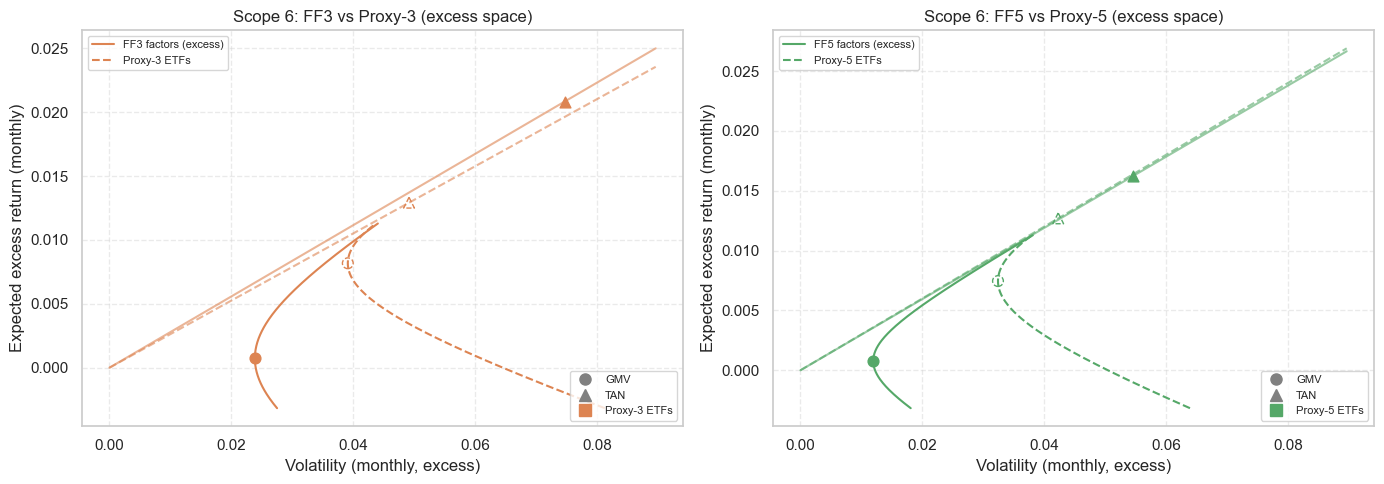

Sharpe ratios (excess space, rf=0; tangency portfolios):
  FF3 factors:  SR = 0.2787
  Proxy-3 ETFs:  SR = 0.2626
  FF5 factors:  SR = 0.2972
  Proxy-5 ETFs:  SR = 0.3000


In [24]:
# Scope 6: Plot FF3 vs proxy-3 and FF5 vs proxy-5 frontiers (excess space)

# Build shared mu-range across factors and proxies
mu_min_q6 = float(min(mu_ff3_6.min(), mu_ff5_6.min(), mu_proxy3.min(), mu_proxy5.min())) - 0.001
mu_max_q6 = float(max(mu_ff3_6.max(), mu_ff5_6.max(), mu_proxy3.max(), mu_proxy5.max())) + 0.001

front_ff3_means, front_ff3_vols, front_ff3_w = efficient_frontier(mu_ff3_6, Sigma_ff3_6, n_points=200, mu_min=mu_min_q6, mu_max=mu_max_q6)
front_proxy3_means, front_proxy3_vols, front_proxy3_w = efficient_frontier(mu_proxy3, Sigma_proxy3, n_points=200, mu_min=mu_min_q6, mu_max=mu_max_q6)

front_ff5_means, front_ff5_vols, front_ff5_w = efficient_frontier(mu_ff5_6, Sigma_ff5_6, n_points=200, mu_min=mu_min_q6, mu_max=mu_max_q6)
front_proxy5_means, front_proxy5_vols, front_proxy5_w = efficient_frontier(mu_proxy5, Sigma_proxy5, n_points=200, mu_min=mu_min_q6, mu_max=mu_max_q6)

# Helper to compute GMV/TAN and Sharpe in excess space (rf = 0)
def gmv_tan_ex(mu, Sigma):
    w_g = gmv_weights(Sigma)
    mu_g, vol_g = portfolio_stats(w_g, mu, Sigma)
    w_t = tangency_weights(mu, Sigma, rf=0.0)
    mu_t, vol_t = portfolio_stats(w_t, mu, Sigma)
    sr = mu_t / vol_t if vol_t > 0 else np.nan
    return (mu_g, vol_g), (mu_t, vol_t, sr)

(gmv_ff3_6, tan_ff3_6) = gmv_tan_ex(mu_ff3_6, Sigma_ff3_6)
(gmv_proxy3_6, tan_proxy3_6) = gmv_tan_ex(mu_proxy3, Sigma_proxy3)
(gmv_ff5_6, tan_ff5_6) = gmv_tan_ex(mu_ff5_6, Sigma_ff5_6)
(gmv_proxy5_6, tan_proxy5_6) = gmv_tan_ex(mu_proxy5, Sigma_proxy5)

(mu_g_ff3_6, vol_g_ff3_6), (mu_t_ff3_6, vol_t_ff3_6, sr_ff3_6) = gmv_ff3_6, tan_ff3_6
(mu_g_proxy3_6, vol_g_proxy3_6), (mu_t_proxy3_6, vol_t_proxy3_6, sr_proxy3_6) = gmv_proxy3_6, tan_proxy3_6
(mu_g_ff5_6, vol_g_ff5_6), (mu_t_ff5_6, vol_t_ff5_6, sr_ff5_6) = gmv_ff5_6, tan_ff5_6
(mu_g_proxy5_6, vol_g_proxy5_6), (mu_t_proxy5_6, vol_t_proxy5_6, sr_proxy5_6) = gmv_proxy5_6, tan_proxy5_6

# Overwrite FF3 tangency with constrained version (w_i >= -1, sum w = 1) so it stays on the chart
w_tan_ff3_c = tangency_weights_constrained(mu_ff3_6, Sigma_ff3_6, rf=0.0, w_min=-1.0)
mu_t_ff3_6, vol_t_ff3_6 = portfolio_stats(w_tan_ff3_c, mu_ff3_6, Sigma_ff3_6)
sr_ff3_6 = (mu_t_ff3_6 / vol_t_ff3_6) if vol_t_ff3_6 > 0 else np.nan
tan_ff3_6 = (mu_t_ff3_6, vol_t_ff3_6, sr_ff3_6)

# CML-style rays from origin in excess space
vol_grid_q6 = np.linspace(0, max(vol_t_ff3_6, vol_t_ff5_6, vol_t_proxy3_6, vol_t_proxy5_6) * 1.2, 150)
mu_cml_ff3_6 = sr_ff3_6 * vol_grid_q6
mu_cml_proxy3_6 = sr_proxy3_6 * vol_grid_q6
mu_cml_ff5_6 = sr_ff5_6 * vol_grid_q6
mu_cml_proxy5_6 = sr_proxy5_6 * vol_grid_q6

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: FF3 vs proxy-3
ax = axes[0]
ax.plot(front_ff3_vols, front_ff3_means, **style("frontier", "ff3"))
ax.plot(front_proxy3_vols, front_proxy3_means, **style("frontier", "ff3", proxy=True))
ax.plot(vol_grid_q6, mu_cml_ff3_6, **style("cml", "ff3", label="CML FF3 (rf=0)"))
ax.plot(vol_grid_q6, mu_cml_proxy3_6, **style("cml", "ff3", proxy=True, label="CML Proxy-3 (rf=0)"))
ax.scatter([vol_g_ff3_6], [mu_g_ff3_6], **style("gmv", "ff3"))
ax.scatter([vol_t_ff3_6], [mu_t_ff3_6], **style("tan", "ff3"))
ax.scatter([vol_g_proxy3_6], [mu_g_proxy3_6], **style("gmv", "ff3", proxy=True))
ax.scatter([vol_t_proxy3_6], [mu_t_proxy3_6], **style("tan", "ff3", proxy=True))
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 6: FF3 vs Proxy-3 (excess space)")
ax.grid(True, linestyle="--", alpha=0.4)
line_handles, marker_handles = scope6_panel_legend_handles("ff3")
leg1 = ax.legend(handles=line_handles, fontsize=8)
ax.add_artist(leg1)
ax.legend(handles=marker_handles, loc="lower right", fontsize=8)

# Right: FF5 vs proxy-5
ax = axes[1]
ax.plot(front_ff5_vols, front_ff5_means, **style("frontier", "ff5"))
ax.plot(front_proxy5_vols, front_proxy5_means, **style("frontier", "ff5", proxy=True))
ax.plot(vol_grid_q6, mu_cml_ff5_6, **style("cml", "ff5", label="CML FF5 (rf=0)"))
ax.plot(vol_grid_q6, mu_cml_proxy5_6, **style("cml", "ff5", proxy=True, label="CML Proxy-5 (rf=0)"))
ax.scatter([vol_g_ff5_6], [mu_g_ff5_6], **style("gmv", "ff5"))
ax.scatter([vol_t_ff5_6], [mu_t_ff5_6], **style("tan", "ff5"))
ax.scatter([vol_g_proxy5_6], [mu_g_proxy5_6], **style("gmv", "ff5", proxy=True))
ax.scatter([vol_t_proxy5_6], [mu_t_proxy5_6], **style("tan", "ff5", proxy=True))
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 6: FF5 vs Proxy-5 (excess space)")
ax.grid(True, linestyle="--", alpha=0.4)
line_handles, marker_handles = scope6_panel_legend_handles("ff5")
leg1 = ax.legend(handles=line_handles, fontsize=8)
ax.add_artist(leg1)
ax.legend(handles=marker_handles, loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()

print("Sharpe ratios (excess space, rf=0; tangency portfolios):")
print(f"  FF3 factors:  SR = {sr_ff3_6:.4f}\n  Proxy-3 ETFs:  SR = {sr_proxy3_6:.4f}")
print(f"  FF5 factors:  SR = {sr_ff5_6:.4f}\n  Proxy-5 ETFs:  SR = {sr_proxy5_6:.4f}")

In [25]:
# --- Scope 6: FF3 tangency diagnostic (constrained: w_i >= -1, sum w = 1) ---
w_tan_ff3 = tangency_weights_constrained(mu_ff3_6, Sigma_ff3_6, rf=0.0, w_min=-1.0)
names_ff3 = list(ff3_6.columns)
print("FF3 tangency portfolio weights:")
for name, w in zip(names_ff3, w_tan_ff3):
    print(f"  {name}: {w:+.4f}")
print(f"  sum(weights): {w_tan_ff3.sum():.6f}")
print(f"  min/max weight: {w_tan_ff3.min():.4f} / {w_tan_ff3.max():.4f}")
print()
print("FF3 GMV (excess space):  mu = {:.6f}, vol = {:.6f}".format(mu_g_ff3_6, vol_g_ff3_6))
print("FF3 tangency (excess):  mu = {:.6f}, vol = {:.6f}, Sharpe = {:.4f}".format(mu_t_ff3_6, vol_t_ff3_6, sr_ff3_6))
# Tangency should lie on CML: mu_t = sr * vol_t (rf=0)
cml_check = sr_ff3_6 * vol_t_ff3_6
print("CML check (mu_t vs sr*vol_t): {:.6f} vs {:.6f}  (diff = {:.2e})".format(mu_t_ff3_6, cml_check, abs(mu_t_ff3_6 - cml_check)))

FF3 tangency portfolio weights:
  Mkt-RF: +1.8355
  SMB: -1.0000
  HML: +0.1645
  sum(weights): 1.000000
  min/max weight: -1.0000 / 1.8355

FF3 GMV (excess space):  mu = 0.000734, vol = 0.023876
FF3 tangency (excess):  mu = 0.020827, vol = 0.074720, Sharpe = 0.2787
CML check (mu_t vs sr*vol_t): 0.020827 vs 0.020827  (diff = 0.00e+00)


**FF3 tangency:** Scope 6 uses a *constrained* tangency for FF3: maximize Sharpe subject to **w_i ≥ −1** (no more than 100% short per factor) and **sum(w) = 1**. This avoids the unconstrained solution’s extreme leverage (~+527% Mkt-RF, ~−460% SMB) so the FF3 tangency point is on the chart and comparable to FF5 and the proxy tangencies.

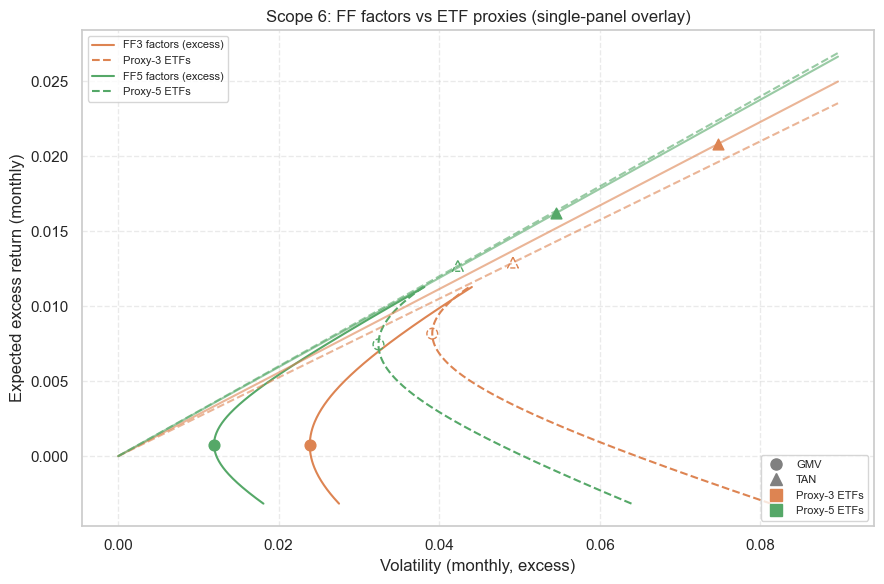

In [ ]:
# Scope 6: Single-panel overlay of FF3/FF5 vs proxy-3/proxy-5 frontiers and CMLs

fig, ax = plt.subplots(figsize=(9, 6))

# Risky frontiers (FF3/proxy3 = C1, FF5/proxy5 = C2; proxy dashed per plot_styles)
ax.plot(front_ff3_vols, front_ff3_means, **style("frontier", "ff3", label="_nolegend_"))
ax.plot(front_proxy3_vols, front_proxy3_means, **style("frontier", "ff3", proxy=True, label="_nolegend_"))
ax.plot(front_ff5_vols, front_ff5_means, **style("frontier", "ff5", label="_nolegend_"))
ax.plot(front_proxy5_vols, front_proxy5_means, **style("frontier", "ff5", proxy=True, label="_nolegend_"))

# CML-style rays (same colours as frontiers)
ax.plot(vol_grid_q6, mu_cml_ff3_6, **style("cml", "ff3", label="_nolegend_"))
ax.plot(vol_grid_q6, mu_cml_proxy3_6, **style("cml", "ff3", proxy=True, label="_nolegend_"))
ax.plot(vol_grid_q6, mu_cml_ff5_6, **style("cml", "ff5", label="_nolegend_"))
ax.plot(vol_grid_q6, mu_cml_proxy5_6, **style("cml", "ff5", proxy=True, label="_nolegend_"))

# GMV and tangency markers (circle/triangle; proxy = hollow)
ax.scatter([vol_g_ff3_6], [mu_g_ff3_6], **style("gmv", "ff3", label="_nolegend_"))
ax.scatter([vol_t_ff3_6], [mu_t_ff3_6], **style("tan", "ff3", label="_nolegend_"))
ax.scatter([vol_g_proxy3_6], [mu_g_proxy3_6], **style("gmv", "ff3", proxy=True, label="_nolegend_"))
ax.scatter([vol_t_proxy3_6], [mu_t_proxy3_6], **style("tan", "ff3", proxy=True, label="_nolegend_"))
ax.scatter([vol_g_ff5_6], [mu_g_ff5_6], **style("gmv", "ff5", label="_nolegend_"))
ax.scatter([vol_t_ff5_6], [mu_t_ff5_6], **style("tan", "ff5", label="_nolegend_"))
ax.scatter([vol_g_proxy5_6], [mu_g_proxy5_6], **style("gmv", "ff5", proxy=True, label="_nolegend_"))
ax.scatter([vol_t_proxy5_6], [mu_t_proxy5_6], **style("tan", "ff5", proxy=True, label="_nolegend_"))

ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 6: FF factors vs ETF proxies (single-panel overlay)")
ax.grid(True, linestyle="--", alpha=0.4)
line_handles, marker_handles = scope6_legend_handles()
leg1 = ax.legend(handles=line_handles, fontsize=8)
ax.add_artist(leg1)
ax.legend(handles=marker_handles, loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Scope 6: Tangency diagnostics for FF3 and FF5 (with/without w_i >= -1)
import pandas as pd

# All factor names so table has consistent columns (FF3 rows will have NaN for RMW, CMA)
all_factor_names = list(ff5_6.columns)

rows = []
for label, (mu_f, Sigma_f), names in [
    ("FF3", (mu_ff3_6, Sigma_ff3_6), list(ff3_6.columns)),
    ("FF5", (mu_ff5_6, Sigma_ff5_6), list(ff5_6.columns)),
]:
    # Unconstrained tangency
    w_u = tangency_weights(mu_f, Sigma_f, rf=0.0)
    mu_u, vol_u = portfolio_stats(w_u, mu_f, Sigma_f)
    sr_u = mu_u / vol_u if vol_u > 0 else np.nan
    row_u = {
        "Model": label,
        "Constraint": "unconstrained",
        "mu_t": mu_u,
        "vol_t": vol_u,
        "Sharpe": sr_u,
        "min_w": w_u.min(),
        "max_w": w_u.max(),
    }
    for i, n in enumerate(all_factor_names):
        row_u[f"w_{n}"] = w_u[i] if i < len(names) else np.nan
    rows.append(row_u)

    # Constrained tangency: w_i >= -1, sum w = 1
    w_c = tangency_weights_constrained(mu_f, Sigma_f, rf=0.0, w_min=-1.0)
    mu_c, vol_c = portfolio_stats(w_c, mu_f, Sigma_f)
    sr_c = mu_c / vol_c if vol_c > 0 else np.nan
    row_c = {
        "Model": label,
        "Constraint": "w_i >= -1",
        "mu_t": mu_c,
        "vol_t": vol_c,
        "Sharpe": sr_c,
        "min_w": w_c.min(),
        "max_w": w_c.max(),
    }
    for i, n in enumerate(all_factor_names):
        row_c[f"w_{n}"] = w_c[i] if i < len(names) else np.nan
    rows.append(row_c)

# Table for report / diagnostics (weights per factor included)
df_tan = pd.DataFrame(rows)
round_cols = {"mu_t": 6, "vol_t": 6, "Sharpe": 4, "min_w": 3, "max_w": 3}
round_cols.update({f"w_{n}": 3 for n in all_factor_names})
print("Tangency diagnostics (monthly excess returns, weights per factor):")
display(df_tan.round(round_cols))

# Frontier weight ranges for FF3 and FF5 (unconstrained frontiers)
for label, W in {
    "FF3 frontier": front_ff3_w,
    "FF5 frontier": front_ff5_w,
}.items():
    print(f"{label}: min weight = {W.min():.3f}, max weight = {W.max():.3f}")


Tangency diagnostics (monthly excess returns, weights per factor):


,Model,Constraint,mu_t,vol_t,Sharpe,min_w,max_w,w_Mkt-RF,w_SMB,w_HML,w_RMW,w_CMA
0,FF3,unconstrained,0.063731,0.222408,0.2865,-4.592,5.271,5.271,-4.592,0.321,NaN,NaN
1,FF3,w_i >= -1,0.020827,0.074720,0.2787,-1.000,1.836,1.836,-1.000,0.164,NaN,NaN
2,FF5,unconstrained,0.016208,0.054528,0.2972,-0.817,1.179,1.179,-0.817,-0.005,0.790,-0.147
3,FF5,w_i >= -1,0.016069,0.054062,0.2972,-0.806,1.170,1.170,-0.806,-0.006,0.784,-0.142


FF3 frontier: min weight = -0.388, max weight = 1.058
FF5 frontier: min weight = -0.458, max weight = 0.819


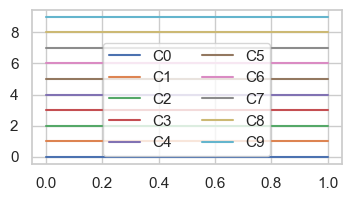

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(4,2))
for i in range(10):
    ax.plot([0,1], [i,i], label=f'C{i}')
ax.legend(ncol=2)
plt.show()


## Scope 7 – In-sample / out-of-sample frontiers and Sharpe ratio tests

Re-estimate monthly MV frontiers for the **30 industry portfolios** and for the **Fama–French 5 Factors (2x3)** mimicking portfolios over two contiguous periods (one ending December 2002, the other ending December 2025), **including the risk-free asset**. Pick at least one portfolio from each in-sample frontier and compare in-sample vs out-of-sample performance. Test equality of Sharpe ratios using **Jobson–Korkie (1981)** (statistic per Jorion 1985, fn 20, p. 271) and **Ledoit–Wolf (2008)** (robust, no i.i.d./normality).

In [34]:
# Scope 7: In-sample frontiers and portfolio selection
# Load period split data first (run previous cell if you prefer to keep them separate)
END_IS, START_OOS, END_OOS = "2002-12", "2003-01", "2025-12"
ind_is = load_industry_30_monthly(end=END_IS)
ind_oos = load_industry_30_monthly(start=START_OOS, end=END_OOS)
ff5_is, rf_is = load_ff5_monthly(end=END_IS)
ff5_oos, rf_oos = load_ff5_monthly(start=START_OOS, end=END_OOS)
ind_net_is = ind_is.values - 1.0
ind_net_oos = ind_oos.values - 1.0
rf_is_net = (rf_is - 1.0).values
rf_oos_net = (rf_oos - 1.0).values

from fin41360.mv_frontier import (
    compute_moments_from_net,
    gmv_weights,
    tangency_weights,
    portfolio_stats,
)

# 30 industries: mean and cov from net returns; RF = average in-sample
mu_ind_is, Sigma_ind_is = compute_moments_from_net(ind_net_is)
rf_ind_is = float(np.mean(rf_is_net))

w_tan_ind = tangency_weights(mu_ind_is, Sigma_ind_is, rf_ind_is)
w_gmv_ind = gmv_weights(Sigma_ind_is)

mu_tan_ind_is, vol_tan_ind_is = portfolio_stats(w_tan_ind, mu_ind_is, Sigma_ind_is)
mu_gmv_ind_is, vol_gmv_ind_is = portfolio_stats(w_gmv_ind, mu_ind_is, Sigma_ind_is)
sr_tan_ind_is = (mu_tan_ind_is - rf_ind_is) / vol_tan_ind_is if vol_tan_ind_is > 0 else np.nan
sr_gmv_ind_is = (mu_gmv_ind_is - rf_ind_is) / vol_gmv_ind_is if vol_gmv_ind_is > 0 else np.nan

# FF5: excess returns (factors); tangency in excess space uses rf=0
ff5_is_arr = ff5_is.values
mu_ff5_is, Sigma_ff5_is = compute_moments_from_net(ff5_is_arr)

w_tan_ff5 = tangency_weights(mu_ff5_is, Sigma_ff5_is, 0.0)
w_gmv_ff5 = gmv_weights(Sigma_ff5_is)

mu_tan_ff5_is, vol_tan_ff5_is = portfolio_stats(w_tan_ff5, mu_ff5_is, Sigma_ff5_is)
mu_gmv_ff5_is, vol_gmv_ff5_is = portfolio_stats(w_gmv_ff5, mu_ff5_is, Sigma_ff5_is)
sr_tan_ff5_is = mu_tan_ff5_is / vol_tan_ff5_is if vol_tan_ff5_is > 0 else np.nan
sr_gmv_ff5_is = mu_gmv_ff5_is / vol_gmv_ff5_is if vol_gmv_ff5_is > 0 else np.nan

print("In-sample portfolios (monthly):")
print("  30 ind TAN: mu={:.4f} vol={:.4f} SR={:.4f}".format(mu_tan_ind_is, vol_tan_ind_is, sr_tan_ind_is))
print("  30 ind GMV: mu={:.4f} vol={:.4f} SR={:.4f}".format(mu_gmv_ind_is, vol_gmv_ind_is, sr_gmv_ind_is))
print("  FF5 TAN:    mu={:.4f} vol={:.4f} SR={:.4f}".format(mu_tan_ff5_is, vol_tan_ff5_is, sr_tan_ff5_is))
print("  FF5 GMV:    mu={:.4f} vol={:.4f} SR={:.4f}".format(mu_gmv_ff5_is, vol_gmv_ff5_is, sr_gmv_ff5_is))

In-sample portfolios (monthly):
  30 ind TAN: mu=0.0258 vol=0.0609 SR=0.3368
  30 ind GMV: mu=0.0107 vol=0.0314 SR=0.1735
  FF5 TAN:    mu=0.0043 vol=0.0108 SR=0.3995
  FF5 GMV:    mu=0.0039 vol=0.0103 SR=0.3789


In [ ]:
# Scope 7: In-sample portfolio return series (for Sharpe tests: IS vs OOS)
r_tan_ind_is = ind_net_is @ w_tan_ind
r_gmv_ind_is = ind_net_is @ w_gmv_ind
r_tan_ff5_is = ff5_is_arr @ w_tan_ff5
r_gmv_ff5_is = ff5_is_arr @ w_gmv_ff5

In [ ]:
# Scope 7: Out-of-sample portfolio returns and statistics
# Apply in-sample weights to OOS returns (same assets, different period)

# 30 industries: portfolio net return each month OOS
r_tan_ind_oos = ind_net_oos @ w_tan_ind
r_gmv_ind_oos = ind_net_oos @ w_gmv_ind
rf_oos_scalar = float(np.mean(rf_oos_net))

# FF5: portfolio excess return each month OOS
r_tan_ff5_oos = ff5_oos.values @ w_tan_ff5
r_gmv_ff5_oos = ff5_oos.values @ w_gmv_ff5

def oos_sharpe(rets_net, rf_net):
    excess = rets_net - rf_net
    return np.mean(excess) / np.std(excess, ddof=1) if np.std(excess, ddof=1) > 0 else np.nan

sr_tan_ind_oos = oos_sharpe(r_tan_ind_oos, rf_oos_net)
sr_gmv_ind_oos = oos_sharpe(r_gmv_ind_oos, rf_oos_net)
# FF5 already excess returns -> Sharpe = mean/vol
sr_tan_ff5_oos = np.mean(r_tan_ff5_oos) / np.std(r_tan_ff5_oos, ddof=1) if np.std(r_tan_ff5_oos, ddof=1) > 0 else np.nan
sr_gmv_ff5_oos = np.mean(r_gmv_ff5_oos) / np.std(r_gmv_ff5_oos, ddof=1) if np.std(r_gmv_ff5_oos, ddof=1) > 0 else np.nan

print("Out-of-sample Sharpe ratios (monthly):")
print("  30 ind TAN: SR_oos = {:.4f}  (SR_is = {:.4f})".format(sr_tan_ind_oos, sr_tan_ind_is))
print("  30 ind GMV: SR_oos = {:.4f}  (SR_is = {:.4f})".format(sr_gmv_ind_oos, sr_gmv_ind_is))
print("  FF5 TAN:    SR_oos = {:.4f}  (SR_is = {:.4f})".format(sr_tan_ff5_oos, sr_tan_ff5_is))
print("  FF5 GMV:    SR_oos = {:.4f}  (SR_is = {:.4f})".format(sr_gmv_ff5_oos, sr_gmv_ff5_is))

In [36]:
# Scope 7: Jobson–Korkie and Ledoit–Wolf tests (in-sample vs out-of-sample Sharpe)
from fin41360.sharpe_tests import jobson_korkie_test, ledoit_wolf_test

portfolios = [
    ("30 ind TAN", r_tan_ind_is, r_tan_ind_oos, rf_ind_is, rf_oos_scalar),
    ("30 ind GMV", r_gmv_ind_is, r_gmv_ind_oos, rf_ind_is, rf_oos_scalar),
    ("FF5 TAN", r_tan_ff5_is, r_tan_ff5_oos, 0.0, 0.0),
    ("FF5 GMV", r_gmv_ff5_is, r_gmv_ff5_oos, 0.0, 0.0),
]

jk_results = []
lw_results = []
for name, r_is, r_oos, rf_is_val, rf_oos_val in portfolios:
    jk = jobson_korkie_test(r_is, r_oos, rf1=rf_is_val, rf2=rf_oos_val)
    lw = ledoit_wolf_test(r_is, r_oos, rf1=rf_is_val, rf2=rf_oos_val, n_boot=2000)
    jk_results.append((name, jk))
    lw_results.append((name, lw))

# Summary table: Jobson–Korkie
print("Jobson–Korkie (1981) test: H0 = same Sharpe in-sample vs out-of-sample")
print(pd.DataFrame([
    {"Portfolio": n, "SR_is": jk.sharpe1, "SR_oos": jk.sharpe2, "z": jk.statistic, "p-value": jk.pvalue_two_sided}
    for n, jk in jk_results
]).to_string(index=False))

# Summary table: Ledoit–Wolf
print("\nLedoit–Wolf (2008) test: 95% bootstrap CI for (SR_is - SR_oos); reject H0 if 0 not in CI")
print(pd.DataFrame([
    {"Portfolio": n, "SR_is": lw.sharpe1, "SR_oos": lw.sharpe2, "CI_low": lw.ci_low, "CI_high": lw.ci_high, "p-value": lw.pvalue_two_sided}
    for n, lw in lw_results
]).to_string(index=False))

NameError: name 'r_tan_ind_oos' is not defined

In [ ]:
# Scope 7: Do in-sample chosen portfolios remain on the efficient frontier out-of-sample?
# Compute OOS frontier and check where (vol, mean) of our portfolios lie

mu_ind_oos, Sigma_ind_oos = compute_moments_from_net(ind_net_oos)
mu_ff5_oos, Sigma_ff5_oos = compute_moments_from_net(ff5_oos.values)

# OOS stats of in-sample portfolios (same weights, OOS moments for mean/vol)
mu_tan_ind_oos, vol_tan_ind_oos = portfolio_stats(w_tan_ind, mu_ind_oos, Sigma_ind_oos)
mu_gmv_ind_oos, vol_gmv_ind_oos = portfolio_stats(w_gmv_ind, mu_ind_oos, Sigma_ind_oos)
mu_tan_ff5_oos, vol_tan_ff5_oos = portfolio_stats(w_tan_ff5, mu_ff5_oos, Sigma_ff5_oos)
mu_gmv_ff5_oos, vol_gmv_ff5_oos = portfolio_stats(w_gmv_ff5, mu_ff5_oos, Sigma_ff5_oos)

# OOS tangency (optimal in OOS period)
w_tan_ind_oos = tangency_weights(mu_ind_oos, Sigma_ind_oos, rf_oos_scalar)
w_tan_ff5_oos = tangency_weights(mu_ff5_oos, Sigma_ff5_oos, 0.0)
m_tan_ind, v_tan_ind = portfolio_stats(w_tan_ind_oos, mu_ind_oos, Sigma_ind_oos)
m_tan_ff5, v_tan_ff5 = portfolio_stats(w_tan_ff5_oos, mu_ff5_oos, Sigma_ff5_oos)
sr_tan_ind_oos_opt = (m_tan_ind - rf_oos_scalar) / v_tan_ind if v_tan_ind > 0 else np.nan
sr_tan_ff5_oos_opt = m_tan_ff5 / v_tan_ff5 if v_tan_ff5 > 0 else np.nan

print("Out-of-sample: in-sample TAN vs OOS-optimal TAN Sharpe")
print("  30 ind: SR(in-sample TAN, OOS) = {:.4f}  vs  SR(OOS TAN) = {:.4f}".format(sr_tan_ind_oos, sr_tan_ind_oos_opt))
print("  FF5:    SR(in-sample TAN, OOS) = {:.4f}  vs  SR(OOS TAN) = {:.4f}".format(sr_tan_ff5_oos, sr_tan_ff5_oos_opt))
print("\nInterpretation: If JK or LW reject equality, the portfolio's Sharpe changed significantly from in-sample to OOS. Whether it 'remains on the frontier' can be assessed by comparing OOS Sharpe of the fixed portfolio to the OOS tangency Sharpe above.")

NameError: name 'rf_oos_scalar' is not defined